# Battery Optimization Problem: simple version with PuLP

This notebook uses the PuLP library to solve the battery optimization problem. The problem setup is highly simplified: consider a battery operator seeking to optimize its charge and discharge schedule in order to maximizes its profit in the energy market over the operating day. The operator has a forecast of hourly energy market prices ($p_{t}$). The battery has a maximum energy storage capacity of $K$, maximum charge and discharge rate of $\delta$, and one-way efficiency of $\eta$.
\begin{align} max \sum_{t=1}^{24} \ p_{t}*(d_{t} - c_{t}) \\
    s.t. \\
    0 \le c_{t} \le \delta \\
    0 \le d_{t} \le \delta \\
    \eta * c_{t} - (1/\eta)*d_{t} - S_{t} + S_{t-1} = 0 \\
    0 \le S_{t} \le K \\
    S_{0}=0
\end{align}

Decision variables:
- $d_{t}$ rate of discharge in hour t (MW)
- $c_{t}$ rate of charge in hour t (MW)

State variable: $S_{t}$ battery state of charge at the end of hour t (MWh)

Parameters:
- $p_{t}$ forecasted hourly energy prices (\$/MWh)
- $\delta$ maximum rate of charge/discharge (MW)
- $\eta$ one-way efficiency losses (\%)
- $K$ maximum state of charge (MWh)


In [1]:
# get necessary libraries
import numpy as np
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# parameter inputs
# hourly price path
prices = [23.59,21.36,20.47,20.3,20.26,21.34,23.97,28.34,31.6,29.18,27.54,25.79,
 25.22,27.17,29.56,31.74,33.81,40.99,41,40.65,37.46,32.13,28.97,26.88]
# battery maximum charge/discharge rates
w = 5
eff = 0.95
# battery maximum energy capacity
K = 10
# battery starting energy level
SOC_begin = 0
# hours of optimization horizon
t_max = 24

In [3]:
# set up the optimization problem
battery_prob = LpProblem("BatteryOptimization",LpMaximize)
# decision variables
charge_var = LpVariable.dicts("c", range(1,t_max+1),0,w) #upper/lower bounds on SOC
discharge_var = LpVariable.dicts("d", range(1,t_max+1),0,w) #upper/lower bounds on SOC
soc_var = LpVariable.dicts("SOC", range(1,t_max+1),0,K) #upper/lower bounds on SOC
# define the objective function
p = {i+1:(prices[i]) for i in range(0,t_max)}
# setup optimization problem
battery_prob += (
    lpSum([-1*p[j] * charge_var[j] for j in range(1,t_max+1)]+
         [p[j] * discharge_var[j] for j in range(1,t_max+1)]),
    'Battery Profit')
# flow balance equations constraints
battery_prob += lpSum(eff*charge_var[1] - (1/eff)*discharge_var[1] - soc_var[1] + SOC_begin) == 0 # first t period is unqiue
for i  in range(2,t_max+1):
    battery_prob += lpSum(eff*charge_var[i] - (1/eff)*discharge_var[i] - soc_var[i] + soc_var[i-1]) == 0 # remaing time periods

In [4]:
# solve linear program
battery_prob.solve()
print('Status: ',LpStatus[battery_prob.status])
print('Optimal Objective Function Value:',value(battery_prob.objective))

Status:  Optimal
Optimal Objective Function Value: 196.28081577872362


In [5]:
opt_df = pd.DataFrame(columns=['var_name','var_val'])
for x in battery_prob.variables():
    var_dict = {'var_name':x.name,
                'var_val':x.varValue}
    var_df = pd.DataFrame(var_dict, index=[0])
    opt_df = var_df if opt_df.empty else pd.concat([opt_df,var_df], ignore_index=True)
opt_df[['var', 'time']] = opt_df['var_name'].str.split("_", expand=True)
opt_df = opt_df.drop(['var_name'], axis=1)
opt_df = opt_df.pivot(columns='var',values='var_val', index='time')
opt_df = opt_df.reset_index()
opt_df['time'] = opt_df['time'].astype(int)
opt_df = opt_df.sort_values(by=['time'])
opt_df.reset_index(drop=True, inplace=True)

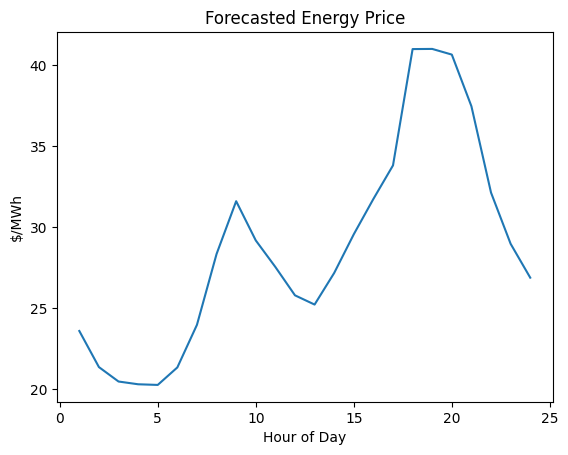

In [7]:
# plot forecasted prices
plt_price = plt.plot(range(1,t_max+1),prices)
plt.title('Forecasted Energy Price')
plt.xlabel('Hour of Day')
plt.ylabel('$/MWh')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

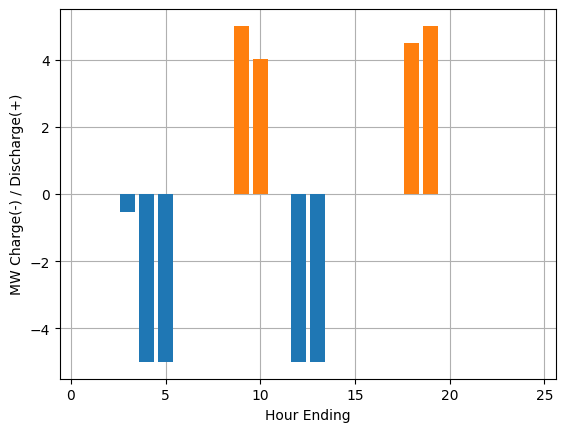

In [8]:
# plot optimal charge and discharge rate
plt.grid(zorder=0)
plt_opt = plt.bar(opt_df['time'],-1*opt_df['c'],zorder=3) + plt.bar(opt_df['time'],opt_df['d'],zorder=3)
#plt.xticks(tm)
plt.xlabel('Hour Ending')
plt.ylabel('MW Charge(-) / Discharge(+)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

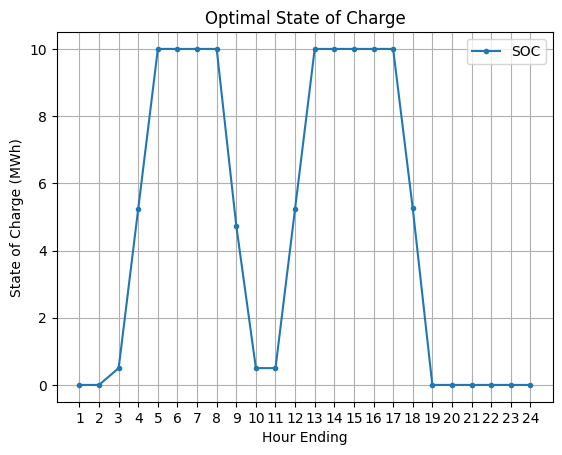

In [9]:
# plot state of charge over the operating day
plt_opt = opt_df.plot(x='time', y='SOC',kind='line', style='.-')
plt.xticks(range(1,t_max+1))
plt.xlabel('Hour Ending')
plt.ylabel('State of Charge (MWh)')
plt.title('Optimal State of Charge')
plt.grid(zorder=0)
plt.show

In [10]:
print('Expected Total Daily Profit: $'+ str(round(value(battery_prob.objective),2)))
print('Clearly, with these prices there is not money in this energy market.')

Expected Total Daily Profit: $196.28
Clearly, with these prices there is not money in this energy market.
